# Tropical Cyclone forecast

This notebook demonstrates how to use the Prithvi-WxC model to perform global weather forecasts. The specific case we will be looking at is the evolution of Hurricane Ida starting August 27 to September 2.

In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

## Input data

We will initialize the forecast at 0Z on August 2021-08-27. To perform long-range forecasts with the Prithvi-WxC model, we need to unroll the model. That means we will perform multiple forecasts reusing the predicted state as input for the next forecast. For this we will need static input data as well as climatology data for all intermediate forecast steps. We can download all required data using the ``get_prithvi_wxc_input`` function.


In [22]:
import numpy as np
from fm4a.download import get_prithvi_wxc_input

initialization_time =np.datetime64("2021-08-27")
get_prithvi_wxc_input(
    initialization_time,
    6, # The time difference in hours between consecutive model steps.
    6 * 24, # Total maximum lead time.
    "input_data",
    "../data"
)

Extracting input data:   0%|                                                                                         | 0/8 [00:00<?, ?it/s]

../data/2021/09/02/MERRA2_401.inst1_2d_asm_Nx.20210902.nc4
../data/2021/09/02/MERRA2_401.inst3_3d_asm_Nv.20210902.nc4
../data/2021/09/02/MERRA2_401.tavg1_2d_flx_Nx.20210902.nc4
../data/2021/09/02/MERRA2_401.tavg1_2d_lnd_Nx.20210902.nc4
../data/2021/09/02/MERRA2_401.tavg1_2d_rad_Nx.20210902.nc4
../data/MERRA2_101.const_2d_ctm_Nx.00000000.nc4
../data/constant/MERRA2_101.const_2d_ctm_Nx.00000000.nc4


Extracting input data: 100%|█████████████████████████████████████████████████████████████████████████████████| 8/8 [00:17<00:00,  2.13s/it]


climate_vertical_doy244_hour06.nc:   0%|          | 0.00/116M [00:00<?, ?B/s]

climate_surface_doy244_hour06.nc:   0%|          | 0.00/20.8M [00:00<?, ?B/s]

climate_vertical_doy244_hour12.nc:   0%|          | 0.00/116M [00:00<?, ?B/s]

climate_surface_doy244_hour12.nc:   0%|          | 0.00/20.8M [00:00<?, ?B/s]

climate_vertical_doy244_hour18.nc:   0%|          | 0.00/116M [00:00<?, ?B/s]

climate_surface_doy244_hour18.nc:   0%|          | 0.00/20.8M [00:00<?, ?B/s]

climate_vertical_doy245_hour00.nc:   0%|          | 0.00/116M [00:00<?, ?B/s]

climate_surface_doy245_hour00.nc:   0%|          | 0.00/20.8M [00:00<?, ?B/s]

## Loading the input data

We use the ``Merra2RolloutDataset`` to load the input data for the roll-out forecast.

In [23]:
from PrithviWxC.dataloaders.merra2_rollout import Merra2RolloutDataset
from fm4a.definitions import (
    LEVELS,
    SURFACE_VARS,
    STATIC_SURFACE_VARS,
    VERTICAL_VARS,
)
dataset = Merra2RolloutDataset(
    time_range=("2021-08-26", "2021-09-18"),
    lead_time=96,
    input_time=-6,
    data_path_surface="input_data",
    data_path_vertical="input_data",
    climatology_path_surface="input_data/climatology",
    climatology_path_vertical="input_data/climatology",
    surface_vars=SURFACE_VARS,
    static_surface_vars=STATIC_SURFACE_VARS,
    vertical_vars=VERTICAL_VARS,
    levels=LEVELS,
    positional_encoding="fourier",
)
len(dataset) > 0, "There doesn't seem to be any valid data."

9

## Loading the model

In [24]:
from fm4a.download import get_prithvi_wxc_scaling_factors
from fm4a.model import load_model
scaling_factor_dir = Path("scaling_factors")
get_prithvi_wxc_scaling_factors(scaling_factor_dir)

In [25]:
model = load_model(
    "small",
    scaling_factor_dir,
    weights="../data/weights/prithvi_wxc_small.pt"
)
model = model.eval().to(device="cuda:1")

## Running the forecast

As mentioned above, in order to perform forecasts over multiple days, we need to unroll the model. The ``Prithvi-WxC`` package provides the ``rollout_iter`` function that implements the unrolling.

In [26]:
import torch
from torch import Tensor, nn

def rollout_iter(
    nsteps: int,
    model: nn.Module,
    batch: dict[str, Tensor | int | float],
    return_intermediate: bool = False
) -> Tensor:
    """A helper function for performing autoregressive rollout.

    Args:
        nsteps (int): The number of rollout steps to take
        model (nn.Module): A model.
        batch (dict): A data dictionary common to the Prithvi models.

    Raises:
        ValueError: If the number of steps isn't positive.

    Returns:
        Tensor: the output of the model after nsteps autoregressive iterations.
    """
    if nsteps < 1:
        raise ValueError("'nsteps' shouold be a positive int.")

    xlast = batch["x"][:, 1]
    batch["lead_time"] = batch["lead_time"][..., 0]

    # Save the masking ratio to be restored later
    mask_ratio_tmp = model.mask_ratio_inputs

    preds = []

    for step in range(nsteps):
        # After first step, turn off masking
        if step > 0:
            model.mask_ratio_inputs = 0.0

        batch["static"] = batch["statics"][:, step]
        batch["climate"] = batch["climates"][:, step]
        batch["y"] = batch["ys"][:, step]

        out = model(batch)
        if return_intermediate:
            preds.append(out.cpu().numpy())

        batch["x"] = torch.cat((xlast[:, None], out[:, None]), dim=1)
        xlast = out

    # Restore the masking ratio
    model.mask_ratio_inputs = mask_ratio_tmp

    if return_intermediate:
        return preds

    return out


In [102]:
import torch
from PrithviWxC.dataloaders.merra2_rollout import preproc

device = "cuda:1"
padding = {"level": [0, 0], "lat": [0, -1], "lon": [0, 0]}
data = next(iter(dataset))
batch = preproc([data], padding)

for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        batch[k] = v.to(device)

rng_state_1 = torch.get_rng_state()
with torch.no_grad():
    model.eval()
    forecast = rollout_iter(dataset.nsteps, model, batch, return_intermediate=True)
valid_times = initialization_time + np.timedelta64(6, "h") * np.arange(1, len(forecast) + 1)

## Display results

Since we are primarily interested in Hurricane Ida's track, we extract a domain over the western Atlantic from the results.

In [103]:
lats = np.rad2deg(batch["static"][0, 0, :, 0].cpu().numpy())
lons = np.rad2deg(batch["static"][0, 1, 0, :].cpu().numpy())

lon_min = -100
lon_max = -70
lat_min = 15
lat_max = 40

lat_mask = (lat_min < lats) * (lats < lat_max)
lon_mask = (lon_min < lons) * (lons < lon_max)

forecast = [tnsr[..., lat_mask, :][..., lon_mask] for tnsr in forecast]
lats = lats[lat_mask]
lons = lons[lon_mask]

Below we extract the Hurricane track from the forecasts by tracking the location of the sea-level-pressure minimum throughout the forecast. We also load Ida's actual track from the HURDAT 2 database.

In [104]:
slp_fcst = [tnsr[0, 9] for tnsr in out]
track = []
for slp in slp_fcst:
    row_ind, col_ind = np.unravel_index(np.argmin(slp), slp.shape)
    track.append([lons[col_ind], lats[row_ind]])

track = np.array(track)

from fm4a.hurdat import get_hurdat_track

hurdat = get_hurdat_track("AL092021")
time_mask = (valid_times.min() <= hurdat.time) * (hurdat.time <= valid_times.max())
hurdat = hurdat[{"time": time_mask}]

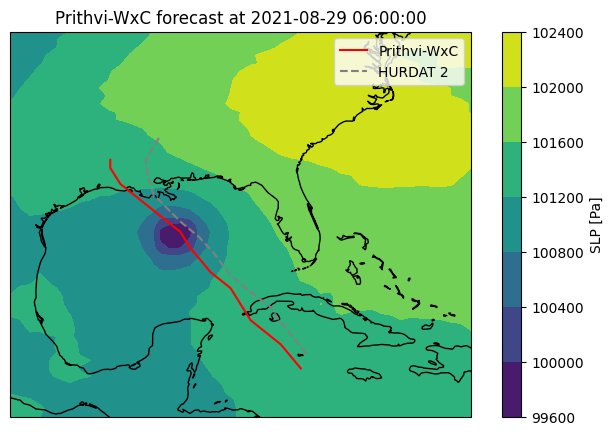

In [101]:
import cartopy.crs as ccrs

crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(8, 5))

step = 8
valid_time = valid_times[step].astype("datetime64[s]").item()

ax = fig.add_subplot(1, 1, 1, projection=crs)
m = ax.contourf(lons, lats, slp_fcst[step])
ax.plot(track[:, 0], track[:, 1], c="red", label="Prithvi-WxC")
ax.plot(hurdat.lon, hurdat.lat, ls="--", color="grey", label="HURDAT 2")
ax.set_title(valid_time.strftime("Prithvi-WxC forecast at %Y-%m-%d %H:%M:%S"))

ax.coastlines()
ax.legend()

plt.colorbar(m, label="SLP [Pa]", ax=ax)